## Copyrights https://raw.githubusercontent.com/zongyi-li

In [ ]:
!wget https://raw.githubusercontent.com/zongyi-li/fourier_neural_operator/master/utilities3.py

--2021-06-10 13:25:25--  https://raw.githubusercontent.com/zongyi-li/fourier_neural_operator/master/utilities3.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8877 (8.7K) [text/plain]
Saving to: ‘utilities3.py’

utilities3.py       100%[===================>]   8.67K  --.-KB/s    in 0s      

2021-06-10 13:25:25 (49.8 MB/s) - ‘utilities3.py’ saved [8877/8877]



# ResNet

## Copyrights https://github.com/akamaster/pytorch_resnet_cifar10/blob/master/resnet.py

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

from torch.autograd import Variable

__all__ = ['ResNet', 'resnet20', 'resnet32', 'resnet44', 'resnet56', 'resnet110', 'resnet1202']

def _weights_init(m):
    classname = m.__class__.__name__
    #print(classname)
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)

class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option='A'):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == 'A':
                """
                For CIFAR10 ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(lambda x:
                                            F.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, planes//4, planes//4), "constant", 0))
            elif option == 'B':
                self.shortcut = nn.Sequential(
                     nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                     nn.BatchNorm2d(self.expansion * planes)
                )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(64, num_classes)

        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def resnet20():
    return ResNet(BasicBlock, [3, 3, 3])


def resnet32():
    return ResNet(BasicBlock, [5, 5, 5])


def resnet44():
    return ResNet(BasicBlock, [7, 7, 7])


def resnet56():
    return ResNet(BasicBlock, [9, 9, 9])


def resnet110():
    return ResNet(BasicBlock, [18, 18, 18])


def resnet1202():
    return ResNet(BasicBlock, [200, 200, 200])

model=resnet20().cuda()

# Model Architecture

In [ ]:
from torchsummary import summary
summary(model, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
            Conv2d-3           [-1, 16, 32, 32]           2,304
       BatchNorm2d-4           [-1, 16, 32, 32]              32
            Conv2d-5           [-1, 16, 32, 32]           2,304
       BatchNorm2d-6           [-1, 16, 32, 32]              32
        BasicBlock-7           [-1, 16, 32, 32]               0
            Conv2d-8           [-1, 16, 32, 32]           2,304
       BatchNorm2d-9           [-1, 16, 32, 32]              32
           Conv2d-10           [-1, 16, 32, 32]           2,304
      BatchNorm2d-11           [-1, 16, 32, 32]              32
       BasicBlock-12           [-1, 16, 32, 32]               0
           Conv2d-13           [-1, 16, 32, 32]           2,304
      BatchNorm2d-14           [-1, 16,

In [3]:
# see the structure of the model
model.eval()

ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=

# Verifying if the CUDA is present

In [ ]:
torch.cuda.is_available()

True

# Function to measure the accuracy

In [ ]:
from __future__ import print_function, absolute_import

__all__ = ['accuracy']

def accuracy(output, target, topk=(1,)):
  """Computes the precision@k for the specified values of k"""
  maxk = max(topk)
  batch_size = target.size(0)

  _, pred = output.topk(maxk, 1, True, True)
  pred = pred.t()
  correct = pred.eq(target.view(1, -1).expand_as(pred))
  res = []
  for k in topk:
    correct_k = correct[:k].view(-1).float().sum(0)
    res.append(correct_k.mul_(100.0 / batch_size))
  return res

In [ ]:
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter

import matplotlib.pyplot as plt

import operator
from functools import reduce
from functools import partial

from timeit import default_timer
from utilities3 import *

import torchvision
import torchvision.transforms as transforms
import os

# Download the dataset using GPU and Batch size of 100
torch.manual_seed(0)
np.random.seed(0)
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100,
                                          shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Defining the criteria for loss functions
criterion = nn.CrossEntropyLoss()
# defining the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

losslist=[]
correct = 0
total = 0
beggining_time=datetime.datetime.now()
print(beggining_time)
for epoch in range(100):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        #inputs, labels = data[0].cuda(), data[1].cuda()
        inputs, labels = data[0].cuda(), data[1].cuda()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        #print(outputs[:,-1,-1,:].shape)
        outputs=outputs
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 99:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            #######################
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            print('Accuracy of the network on the 10000 test images: %f %%' % (100 * correct / total))
            losslist.append([(epoch+1), (i + 1),(running_loss / 100),(100 * correct / total)])
            #######################
            running_loss = 0.0
    colunas=["Epoch","Sample", "Loss", "Accuracy"]
    resultado=pd.DataFrame(losslist,columns=colunas)
    resultado.to_pickle("resnet"+str(epoch)+".pickle")
    torch.save(model.state_dict(),"model_resnet.pth")
end_time=datetime.datetime.now()
print(end_time-beggining_time)

Files already downloaded and verified
Files already downloaded and verified
2021-06-09 17:50:51.118620
[1,   100] loss: 2.385
Accuracy of the network on the 10000 test images: 33.000000 %
[1,   200] loss: 1.810
Accuracy of the network on the 10000 test images: 32.500000 %
[1,   300] loss: 1.656
Accuracy of the network on the 10000 test images: 38.333333 %
[1,   400] loss: 1.585
Accuracy of the network on the 10000 test images: 40.500000 %
[1,   500] loss: 1.535
Accuracy of the network on the 10000 test images: 43.200000 %
[2,   100] loss: 1.473
Accuracy of the network on the 10000 test images: 42.833333 %
[2,   200] loss: 1.448
Accuracy of the network on the 10000 test images: 43.285714 %
[2,   300] loss: 1.425
Accuracy of the network on the 10000 test images: 44.375000 %
[2,   400] loss: 1.409
Accuracy of the network on the 10000 test images: 45.333333 %
[2,   500] loss: 1.368
Accuracy of the network on the 10000 test images: 46.600000 %
[3,   100] loss: 1.343
Accuracy of the network 

# Metrics for testing dataset and Resnet20

In [ ]:
from sklearn.metrics import classification_report

## Import the model to validate

In [ ]:
model.load_state_dict(
    torch.load("model_resnet.pth"))

<All keys matched successfully>

In [ ]:
import torchvision
import torchvision
import torchvision.transforms as transforms

## Open the dataset

In [ ]:
torch.manual_seed(0)
np.random.seed(0)
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10,
                                          shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=10,
                                         shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

from torch.autograd import Variable

__all__ = ['ResNet', 'resnet20', 'resnet32', 'resnet44', 'resnet56', 'resnet110', 'resnet1202']

def _weights_init(m):
    classname = m.__class__.__name__
    #print(classname)
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)

class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option='A'):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == 'A':
                """
                For CIFAR10 ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(lambda x:
                                            F.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, planes//4, planes//4), "constant", 0))
            elif option == 'B':
                self.shortcut = nn.Sequential(
                     nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                     nn.BatchNorm2d(self.expansion * planes)
                )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(64, num_classes)

        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def resnet20():
    return ResNet(BasicBlock, [3, 3, 3])


def resnet32():
    return ResNet(BasicBlock, [5, 5, 5])


def resnet44():
    return ResNet(BasicBlock, [7, 7, 7])


def resnet56():
    return ResNet(BasicBlock, [9, 9, 9])


def resnet110():
    return ResNet(BasicBlock, [18, 18, 18])


def resnet1202():
    return ResNet(BasicBlock, [200, 200, 200])

model=resnet18().cuda()

In [ ]:
model.load_state_dict(
    torch.load("model_resnet.pth"))

<All keys matched successfully>

## Creating the confusion matrix for testing dataset and ResNet20

In [ ]:
nb_classes = 10
confusion_matrix_resnet_test = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].cuda(), data[1].cuda()
        #images, labels = data[0], data[1]

        outputs = model(images)#[:,-1,-1,:]
        _, predicted = torch.max(outputs.data, 1)
        for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix_resnet_test[t.long(), p.long()] += 1

print(confusion_matrix_resnet_test)

tensor([[722.,  26.,  69.,  25.,  23.,  12.,  12.,  17.,  57.,  37.],
        [ 49., 671.,   8.,  26.,  12.,  21.,  30.,  11.,  37., 135.],
        [ 78.,  12., 501.,  73.,  92.,  83.,  96.,  33.,  16.,  16.],
        [ 33.,  11.,  93., 408.,  91., 186.,  95.,  30.,  25.,  28.],
        [ 30.,  10.,  97.,  69., 524.,  68.,  94.,  75.,  17.,  16.],
        [ 25.,  10.,  82., 172.,  64., 520.,  50.,  45.,  12.,  20.],
        [ 14.,  19.,  51.,  81.,  56.,  39., 692.,  11.,  16.,  21.],
        [ 32.,  15.,  46.,  81., 113.,  93.,  19., 572.,   6.,  23.],
        [141.,  42.,  30.,  21.,  17.,  19.,  16.,  10., 666.,  38.],
        [ 46.,  85.,   8.,  49.,  15.,  21.,  25.,  23.,  39., 689.]])


## Transforming into DataFrame for a better visualization

In [ ]:
confusion_matrix_resnet_test_df=pd.DataFrame(confusion_matrix_resnet_test.numpy(),columns=classes, index=classes)

In [ ]:
confusion_matrix_resnet_test_df

,plane,car,bird,cat,deer,dog,frog,horse,ship,truck
plane,722.0,26.0,69.0,25.0,23.0,12.0,12.0,17.0,57.0,37.0
car,49.0,671.0,8.0,26.0,12.0,21.0,30.0,11.0,37.0,135.0
bird,78.0,12.0,501.0,73.0,92.0,83.0,96.0,33.0,16.0,16.0
cat,33.0,11.0,93.0,408.0,91.0,186.0,95.0,30.0,25.0,28.0
deer,30.0,10.0,97.0,69.0,524.0,68.0,94.0,75.0,17.0,16.0
dog,25.0,10.0,82.0,172.0,64.0,520.0,50.0,45.0,12.0,20.0
frog,14.0,19.0,51.0,81.0,56.0,39.0,692.0,11.0,16.0,21.0
horse,32.0,15.0,46.0,81.0,113.0,93.0,19.0,572.0,6.0,23.0
ship,141.0,42.0,30.0,21.0,17.0,19.0,16.0,10.0,666.0,38.0
truck,46.0,85.0,8.0,49.0,15.0,21.0,25.0,23.0,39.0,689.0


## Couting the number of each obvervation by class

In [ ]:
confusion_matrix_resnet_test_df.sum()

plane    1170.0
car       901.0
bird      985.0
cat      1005.0
deer     1007.0
dog      1062.0
frog     1129.0
horse     827.0
ship      891.0
truck    1023.0
dtype: float32

## Measuring the accuracy by class in a array format

In [ ]:
# accuracy per class
print(confusion_matrix_resnet_test.diag()/confusion_matrix_resnet_test.sum(1))

tensor([0.7220, 0.6710, 0.5010, 0.4080, 0.5240, 0.5200, 0.6920, 0.5720, 0.6660,
        0.6890])


In [ ]:
import numpy as np

## Measuring the overall accuracy for ResNet20 in testing dataset

In [ ]:
(confusion_matrix_resnet_test.diag()/confusion_matrix_resnet_test.sum(1)).mean()

tensor(0.5965)

## Putting the output in a dataframe format for a better visualization

In [ ]:
topk=pd.DataFrame((confusion_matrix_resnet_test.diag()/confusion_matrix_resnet_test.sum(1)).numpy()).T
topk.index=["Accuracy"]
topk.columns=classes
topk

,plane,car,bird,cat,deer,dog,frog,horse,ship,truck
Accuracy,0.722,0.671,0.501,0.408,0.524,0.52,0.692,0.572,0.666,0.689


## Measuring the Recall and Precision for testing dataset and ResNet20

In [ ]:
recall = np.diag(confusion_matrix_resnet_test_df) / np.sum(confusion_matrix_resnet_test_df, axis = 1)
precision = np.diag(confusion_matrix_resnet_test_df) / np.sum(confusion_matrix_resnet_test_df, axis = 0)

In [ ]:
precision

plane    0.617094
car      0.744728
bird     0.508629
cat      0.405970
deer     0.520357
dog      0.489642
frog     0.612932
horse    0.691657
ship     0.747475
truck    0.673509
dtype: float32

In [ ]:
recall

plane    0.722
car      0.671
bird     0.501
cat      0.408
deer     0.524
dog      0.520
frog     0.692
horse    0.572
ship     0.666
truck    0.689
dtype: float32

In [ ]:
#overall recall and precision
print(np.mean(recall),
np.mean(precision))

0.596500039100647 0.6011993288993835


## Measuring the F-Score for testing dataset and ResNet20

In [ ]:
2*(precision*recall)/(precision+recall)

plane    0.665438
car      0.705944
bird     0.504786
cat      0.406983
deer     0.522172
dog      0.504365
frog     0.650070
horse    0.626163
ship     0.704389
truck    0.681167
dtype: float32

## Overall f-score for testing dataset and ResNet20

In [ ]:
(2*(precision*recall)/(precision+recall)).mean()

0.5971476435661316

# Metrics for training dataset and ResNet20

## Creating the confusion matrix for testing dataset and ResNet20

In [ ]:
nb_classes = 10

confusion_matrix_resnet_train = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for data in trainloader:
        images, labels = data[0].cuda(), data[1].cuda()
        #images, labels = data[0], data[1]

        outputs = model(images)#[:,-1,-1,:]
        _, predicted = torch.max(outputs.data, 1)
        for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix_resnet_train[t.long(), p.long()] += 1

print(confusion_matrix_resnet_train)

tensor([[4431.,   51.,  172.,   31.,   73.,   35.,   43.,   41.,   69.,   54.],
        [ 111., 4345.,   31.,   67.,   28.,   29.,   57.,   31.,   67.,  234.],
        [ 113.,   36., 4214.,   79.,  146.,  106.,  216.,   43.,   23.,   24.],
        [  67.,   28.,  163., 4029.,  132.,  217.,  192.,   56.,   72.,   44.],
        [  94.,   27.,  156.,  120., 4127.,  112.,  193.,  119.,   28.,   24.],
        [  31.,   15.,  137.,  210.,  121., 4240.,  109.,   60.,   28.,   49.],
        [  32.,   43.,   98.,  152.,   94.,   89., 4406.,   14.,   27.,   45.],
        [  82.,   30.,  102.,  200.,  240.,  205.,   35., 4016.,   18.,   72.],
        [ 309.,   89.,   77.,   84.,   50.,   34.,   46.,   23., 4204.,   84.],
        [  95.,  106.,   28.,   97.,   34.,   81.,   62.,   33.,   75., 4389.]])


## Tranforming into dataframe for a better visualization

In [ ]:
confusion_matrix_resnet_train_df=pd.DataFrame(confusion_matrix_resnet_train.numpy(),columns=classes, index=classes)

In [ ]:
confusion_matrix_resnet_train_df

,plane,car,bird,cat,deer,dog,frog,horse,ship,truck
plane,4431.0,51.0,172.0,31.0,73.0,35.0,43.0,41.0,69.0,54.0
car,111.0,4345.0,31.0,67.0,28.0,29.0,57.0,31.0,67.0,234.0
bird,113.0,36.0,4214.0,79.0,146.0,106.0,216.0,43.0,23.0,24.0
cat,67.0,28.0,163.0,4029.0,132.0,217.0,192.0,56.0,72.0,44.0
deer,94.0,27.0,156.0,120.0,4127.0,112.0,193.0,119.0,28.0,24.0
dog,31.0,15.0,137.0,210.0,121.0,4240.0,109.0,60.0,28.0,49.0
frog,32.0,43.0,98.0,152.0,94.0,89.0,4406.0,14.0,27.0,45.0
horse,82.0,30.0,102.0,200.0,240.0,205.0,35.0,4016.0,18.0,72.0
ship,309.0,89.0,77.0,84.0,50.0,34.0,46.0,23.0,4204.0,84.0
truck,95.0,106.0,28.0,97.0,34.0,81.0,62.0,33.0,75.0,4389.0


## counting the number of observation by class

In [ ]:
confusion_matrix_resnet_train_df.sum()

plane    5365.0
car      4770.0
bird     5178.0
cat      5069.0
deer     5045.0
dog      5148.0
frog     5359.0
horse    4436.0
ship     4611.0
truck    5019.0
dtype: float32

## Measuring the accuracy by class in a array format

In [ ]:
# accuracy per class
print(confusion_matrix_resnet_train.diag()/confusion_matrix_resnet_train.sum(1))

tensor([0.8862, 0.8690, 0.8428, 0.8058, 0.8254, 0.8480, 0.8812, 0.8032, 0.8408,
        0.8778])


## Measuring the overall accuracy for training dataset and ResNet20

In [ ]:
(confusion_matrix_resnet_train.diag()/confusion_matrix_resnet_train.sum(1)).mean()

tensor(0.8480)

In [ ]:
topk=pd.DataFrame((confusion_matrix_resnet_train.diag()/confusion_matrix_resnet_train.sum(1)).numpy()).T
topk.index=["Accuracy"]
topk.columns=classes
topk

,plane,car,bird,cat,deer,dog,frog,horse,ship,truck
Accuracy,0.8862,0.869,0.8428,0.8058,0.8254,0.848,0.8812,0.8032,0.8408,0.8778


## Measuring the Recall and Precision for training dataset and ResNet20

In [ ]:
recall = np.diag(confusion_matrix_resnet_train_df) / np.sum(confusion_matrix_resnet_train_df, axis = 1)
precision = np.diag(confusion_matrix_resnet_train_df) / np.sum(confusion_matrix_resnet_train_df, axis = 0)

In [ ]:
recall

plane    0.8862
car      0.8690
bird     0.8428
cat      0.8058
deer     0.8254
dog      0.8480
frog     0.8812
horse    0.8032
ship     0.8408
truck    0.8778
dtype: float32

In [ ]:
precision

plane    0.825909
car      0.910901
bird     0.813828
cat      0.794831
deer     0.818038
dog      0.823621
frog     0.822168
horse    0.905320
ship     0.911733
truck    0.874477
dtype: float32

In [ ]:
#overall recall and precision
print(np.mean(recall),
np.mean(precision))

0.8480199575424194 0.8500825762748718


## Measuring the F-Score for training dataset and ResNet20

In [ ]:
2*(precision*recall)/(precision+recall)

plane    0.854993
car      0.889458
bird     0.828061
cat      0.800278
deer     0.821702
dog      0.835633
frog     0.850661
horse    0.851208
ship     0.874831
truck    0.876135
dtype: float32

## Measuring the overall f-score for training dataset and ResNet20

In [ ]:
(2*(precision*recall)/(precision+recall)).mean()

0.8482959866523743

# Fourier Neural Operator

## Checking the Python Version

In [ ]:
!python --version

Python 3.7.10


## Make sure the PyTorch and TorchVision have the same version used in the paper

In [ ]:
%pip install torch==1.7.1 torchvision==0.8.2 

## Defining the Neural Network FNO

In [ ]:
import datetime
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import pandas as pd

import matplotlib.pyplot as plt

import operator
from functools import reduce
from functools import partial

from timeit import default_timer
from utilities3 import *

import torchvision
import torchvision.transforms as transforms

torch.manual_seed(0)
np.random.seed(0)

#Complex multiplication

class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes):
        super(SpectralConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, 2))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, 2))

    def compl_mul2d(self, a, b):
      op = partial(torch.einsum, "bixy,ioxy->boxy")
      return torch.stack([
          op(a[..., 0], b[..., 0]) - op(a[..., 1], b[..., 1]),
          op(a[..., 1], b[..., 0]) + op(a[..., 0], b[..., 1])
      ], dim=-1)
      
    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.rfft(x, 2, normalized=True, onesided=True)
        out_ft = torch.zeros(batchsize, x.size(-2),  x.size(-2), x.size(-1)//2 + 1, 2, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        #Return to physical space
        x = torch.irfft(out_ft, 2, normalized=True, onesided=True, signal_sizes=( x.size(-2), x.size(-1)))
        return x


class SimpleBlock2d(nn.Module):
    def __init__(self, modes):
        super(SimpleBlock2d, self).__init__()

        self.conv1 = SpectralConv2d(1, 16, modes=modes)
        self.conv2 = SpectralConv2d(16, 32, modes=modes)
        self.conv3 = SpectralConv2d(32, 64, modes=modes)

        self.pool = nn.MaxPool2d(2, 2)


        self.fc1 = nn.Linear(64 * 14 * 14, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = self.pool(x)

        x = x.view(-1, 64 * 14 * 14)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

class Net2d(nn.Module):
    def __init__(self):
        super(Net2d, self).__init__()

        self.conv = SimpleBlock2d(5)

    def forward(self, x):
        x = self.conv(x)

        return x.squeeze(-1)

    def count_params(self):
        c = 0
        for p in self.parameters():
            c += reduce(operator.mul, list(p.size()))

        return c


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, modes=10):
        super(BasicBlock, self).__init__()
        self.conv1 = SpectralConv2d(in_planes, planes, modes=modes)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = SpectralConv2d(planes, planes, modes=modes)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                SpectralConv2d(in_planes, self.expansion*planes, modes=modes),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet_FNO(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet_FNO, self).__init__()
        self.in_planes = 32

        self.conv1 = SpectralConv2d(3, 32, modes=10)
        self.bn1 = nn.BatchNorm2d(32)
        self.layer1 = self._make_layer(block, 32, num_blocks[0], stride=1, modes=3)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=1, modes=3)
        self.layer3 = self._make_layer(block, 32, num_blocks[2], stride=1, modes=3)
        self.layer4 = self._make_layer(block, 32, num_blocks[3], stride=1, modes=3)
        self.linear1 = nn.Linear(32*64*block.expansion, num_classes)
        # self.linear2 = nn.Linear(100, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride, modes=10):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride, modes))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.layer1(out)
        # out = F.avg_pool2d(out, 2)
        out = self.layer2(out)
        # out = F.avg_pool2d(out, 2)
        out = self.layer3(out)
        # out = F.avg_pool2d(out, 2)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        # print(out.shape)
        out = out.view(out.size(0), -1)
        out = self.linear1(out)
        # out = F.relu(out)
        # out = self.linear2(out)
        return out

def ResNet_FNO_18():
    return ResNet_FNO(BasicBlock, [3, 4, 23, 3])

## Cifar10
torch.manual_seed(0)
np.random.seed(0)
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100,
                                          shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

model = ResNet_FNO_18().cuda()

Files already downloaded and verified
Files already downloaded and verified


## The structure of the FNO

In [ ]:
model.eval()

ResNet_FNO(
  (conv1): SpectralConv2d()
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): SpectralConv2d()
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): SpectralConv2d()
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): SpectralConv2d()
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): SpectralConv2d()
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (2): BasicBlock(
      (conv1): SpectralConv2d()
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): SpectralConv2d()
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1,

## The Architecture of FNO

In [ ]:
from torchsummary import summary
summary(model,  (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
    SpectralConv2d-1           [-1, 32, 32, 32]               0
       BatchNorm2d-2           [-1, 32, 32, 32]              64
    SpectralConv2d-3           [-1, 32, 32, 32]               0
       BatchNorm2d-4           [-1, 32, 32, 32]              64
    SpectralConv2d-5           [-1, 32, 32, 32]               0
       BatchNorm2d-6           [-1, 32, 32, 32]              64
        BasicBlock-7           [-1, 32, 32, 32]               0
    SpectralConv2d-8           [-1, 32, 32, 32]               0
       BatchNorm2d-9           [-1, 32, 32, 32]              64
   SpectralConv2d-10           [-1, 32, 32, 32]               0
      BatchNorm2d-11           [-1, 32, 32, 32]              64
       BasicBlock-12           [-1, 32, 32, 32]               0
   SpectralConv2d-13           [-1, 32, 32, 32]               0
      BatchNorm2d-14           [-1, 32,

# Training the neural network FNO

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
losslist=[]
correct = 0
total = 0
beginning_time=datetime.datetime.now()
print(beginning_time)
for epoch in range(100):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        #inputs, labels = data[0].cuda(), data[1].cuda()
        inputs, labels = data[0].cuda(), data[1].cuda()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        outputs=outputs
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 99:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            #######################
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            print('Accuracy of the network on the 10000 test images: %f %%' % (100 * correct / total))
            losslist.append([(epoch+1), (i + 1),(running_loss / 100),(100 * correct / total)])
            #######################
            running_loss = 0.0
    colunas=["Epoch","Sample", "Loss", "Accuracy"]
    resultado=pd.DataFrame(losslist,columns=colunas)
    resultado.to_pickle(str(epoch)+".pickle")
    torch.save(model.state_dict(),"model_parte1.pth")
end_time=datetime.datetime.now()
print(end_time-beginning_time)

2021-06-09 18:31:03.214626
[1,   100] loss: 3.347
Accuracy of the network on the 10000 test images: 15.000000 %
[1,   200] loss: 2.765
Accuracy of the network on the 10000 test images: 17.000000 %
[1,   300] loss: 2.513
Accuracy of the network on the 10000 test images: 18.000000 %
[1,   400] loss: 2.691
Accuracy of the network on the 10000 test images: 18.000000 %
[1,   500] loss: 2.488
Accuracy of the network on the 10000 test images: 16.600000 %
[2,   100] loss: 2.383
Accuracy of the network on the 10000 test images: 18.166667 %
[2,   200] loss: 2.528
Accuracy of the network on the 10000 test images: 16.714286 %
[2,   300] loss: 2.607
Accuracy of the network on the 10000 test images: 17.125000 %
[2,   400] loss: 2.487
Accuracy of the network on the 10000 test images: 17.555556 %
[2,   500] loss: 2.474
Accuracy of the network on the 10000 test images: 17.700000 %
[3,   100] loss: 2.319
Accuracy of the network on the 10000 test images: 18.181818 %
[3,   200] loss: 2.273
Accuracy of the

# GPU configuration 

In [ ]:
#25gb usando 2 de ram
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Jun  9 00:13:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P0    46W / 250W |   4635MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Fim do teste

#Métricas do Fourier

In [ ]:
model = ResNet_FNO_18().cuda()

In [ ]:
model.load_state_dict(
    torch.load("model_parte1.pth"))

## Opening the datasets

In [ ]:
torch.manual_seed(0)
np.random.seed(0)
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100,
                                          shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Generating the confusion matrix for Testing dataset and FNO

In [ ]:
nb_classes = 10

confusion_matrix_fno_test = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].cuda(), data[1].cuda()
        #images, labels = data[0], data[1]

        outputs = model(images)#[:,-1,-1,:]
        _, predicted = torch.max(outputs.data, 1)
        for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix_fno_test[t.long(), p.long()] += 1

print(confusion_matrix_fno_test)

tensor([[732.,  19.,  53.,  22.,  40.,  12.,  17.,  17.,  51.,  37.],
        [ 17., 804.,   8.,  14.,   8.,   7.,  20.,   7.,  21.,  94.],
        [ 75.,  11., 518.,  75., 124.,  66.,  77.,  30.,  12.,  12.],
        [ 44.,  28.,  82., 420.,  94., 172.,  78.,  43.,  13.,  26.],
        [ 18.,   5.,  49.,  70., 692.,  50.,  55.,  44.,  10.,   7.],
        [ 17.,   6.,  57., 174.,  74., 545.,  45.,  61.,   9.,  12.],
        [  9.,  14.,  34.,  63.,  81.,  37., 735.,   6.,   9.,  12.],
        [ 10.,   9.,  25.,  50.,  75.,  64.,  15., 734.,   1.,  17.],
        [108.,  42.,  15.,  26.,  34.,  11.,  11.,  10., 712.,  31.],
        [ 36., 102.,  14.,  21.,  18.,  23.,  12.,  26.,  33., 715.]])


## Transforming into dataframe format for a better visualization

In [ ]:
confusion_matrix_fno_test_df=pd.DataFrame(confusion_matrix_fno_test.numpy(),columns=classes, index=classes)

In [ ]:
confusion_matrix_fno_test_df

,plane,car,bird,cat,deer,dog,frog,horse,ship,truck
plane,732.0,19.0,53.0,22.0,40.0,12.0,17.0,17.0,51.0,37.0
car,17.0,804.0,8.0,14.0,8.0,7.0,20.0,7.0,21.0,94.0
bird,75.0,11.0,518.0,75.0,124.0,66.0,77.0,30.0,12.0,12.0
cat,44.0,28.0,82.0,420.0,94.0,172.0,78.0,43.0,13.0,26.0
deer,18.0,5.0,49.0,70.0,692.0,50.0,55.0,44.0,10.0,7.0
dog,17.0,6.0,57.0,174.0,74.0,545.0,45.0,61.0,9.0,12.0
frog,9.0,14.0,34.0,63.0,81.0,37.0,735.0,6.0,9.0,12.0
horse,10.0,9.0,25.0,50.0,75.0,64.0,15.0,734.0,1.0,17.0
ship,108.0,42.0,15.0,26.0,34.0,11.0,11.0,10.0,712.0,31.0
truck,36.0,102.0,14.0,21.0,18.0,23.0,12.0,26.0,33.0,715.0


## Checking the number of observation for each class in testing dataset and FNO classification

In [ ]:
confusion_matrix_fno_test_df.sum()

plane    1066.0
car      1040.0
bird      855.0
cat       935.0
deer     1240.0
dog       987.0
frog     1065.0
horse     978.0
ship      871.0
truck     963.0
dtype: float32

## Measuring the accuracy by class in testing dataset and FNO (array format)

In [ ]:
# accuracy per class
print(confusion_matrix_fno_test.diag()/confusion_matrix_fno_test.sum(1))

tensor([0.7320, 0.8040, 0.5180, 0.4200, 0.6920, 0.5450, 0.7350, 0.7340, 0.7120,
        0.7150])


## Measuring the overall accuracy for FNO and Testing dataset

In [ ]:
(confusion_matrix_fno_test.diag()/confusion_matrix_fno_test.sum(1)).mean()

tensor(0.6607)

## Accuracy by class in dataframe format (better visualization) - testing dataset and FNO

In [ ]:
topk=pd.DataFrame((confusion_matrix_fno_test.diag()/confusion_matrix_fno_test.sum(1)).numpy()).T
topk.index=["Accuracy"]
topk.columns=classes
topk

,plane,car,bird,cat,deer,dog,frog,horse,ship,truck
Accuracy,0.732,0.804,0.518,0.42,0.692,0.545,0.735,0.734,0.712,0.715


## Measuring the Recall and Precision for Testing dataset and FNO

In [ ]:
recall = np.diag(confusion_matrix_fno_test_df) / np.sum(confusion_matrix_fno_test_df, axis = 1)
precision = np.diag(confusion_matrix_fno_test_df) / np.sum(confusion_matrix_fno_test_df, axis = 0)

In [ ]:
recall

plane    0.732
car      0.804
bird     0.518
cat      0.420
deer     0.692
dog      0.545
frog     0.735
horse    0.734
ship     0.712
truck    0.715
dtype: float32

In [ ]:
precision

plane    0.686679
car      0.773077
bird     0.605848
cat      0.449198
deer     0.558065
dog      0.552178
frog     0.690141
horse    0.750511
ship     0.817451
truck    0.742471
dtype: float32

In [ ]:
#overall recall and precision
print(np.mean(recall),
np.mean(precision))

0.6607000231742859 0.6625618934631348


## F-Score for testing dataset and FNO

In [ ]:
2*(precision*recall)/(precision+recall)

plane    0.708616
car      0.788235
bird     0.558491
cat      0.434109
deer     0.617857
dog      0.548566
frog     0.711864
horse    0.742164
ship     0.761090
truck    0.728477
dtype: float32

## Measuring the overall f-score for testing dataset and FNO

In [ ]:
(2*(precision*recall)/(precision+recall)).mean()

0.6599467992782593

# Metrics for training dataset and FNO

## Generating the confusion matrix for training dataset and FNO

In [ ]:
nb_classes = 10

confusion_matrix_fno_train = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for data in trainloader:
        images, labels = data[0].cuda(), data[1].cuda()
        #images, labels = data[0], data[1]

        outputs = model(images)#[:,-1,-1,:]
        _, predicted = torch.max(outputs.data, 1)
        for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix_fno_train[t.long(), p.long()] += 1

print(confusion_matrix_fno_train)

tensor([[4.9720e+03, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.1000e+01, 2.0000e+00,
         0.0000e+00, 4.0000e+00, 5.0000e+00, 3.0000e+00],
        [6.0000e+00, 4.9840e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 4.0000e+00, 6.0000e+00],
        [1.0000e+01, 1.0000e+00, 4.9560e+03, 3.0000e+00, 1.9000e+01, 2.0000e+00,
         2.0000e+00, 5.0000e+00, 2.0000e+00, 0.0000e+00],
        [3.0000e+00, 1.0000e+00, 1.0000e+00, 4.9720e+03, 1.0000e+01, 3.0000e+00,
         2.0000e+00, 3.0000e+00, 4.0000e+00, 1.0000e+00],
        [2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.9980e+03, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [2.0000e+00, 2.0000e+00, 0.0000e+00, 2.0000e+00, 1.3000e+01, 4.9760e+03,
         1.0000e+00, 1.0000e+00, 2.0000e+00, 1.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 4.0000e+00, 4.0000e+00, 0.0000e+00,
         4.9920e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000

## Putting in the dataframe format for a better visualization

In [ ]:
confusion_matrix_fno_train_df=pd.DataFrame(confusion_matrix_fno_train.numpy(),columns=classes, index=classes)

In [ ]:
confusion_matrix_fno_train_df

,plane,car,bird,cat,deer,dog,frog,horse,ship,truck
plane,4972.0,1.0,1.0,1.0,11.0,2.0,0.0,4.0,5.0,3.0
car,6.0,4984.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,6.0
bird,10.0,1.0,4956.0,3.0,19.0,2.0,2.0,5.0,2.0,0.0
cat,3.0,1.0,1.0,4972.0,10.0,3.0,2.0,3.0,4.0,1.0
deer,2.0,0.0,0.0,0.0,4998.0,0.0,0.0,0.0,0.0,0.0
dog,2.0,2.0,0.0,2.0,13.0,4976.0,1.0,1.0,2.0,1.0
frog,0.0,0.0,0.0,4.0,4.0,0.0,4992.0,0.0,0.0,0.0
horse,0.0,0.0,1.0,2.0,6.0,2.0,2.0,4986.0,1.0,0.0
ship,75.0,19.0,6.0,4.0,10.0,3.0,2.0,1.0,4869.0,11.0
truck,10.0,6.0,2.0,1.0,6.0,1.0,2.0,2.0,2.0,4968.0


## Couting the number of observation of each class in the training dataset and FNO classification

In [ ]:
confusion_matrix_fno_train_df.sum()

plane    5080.0
car      5014.0
bird     4967.0
cat      4989.0
deer     5077.0
dog      4989.0
frog     5003.0
horse    5002.0
ship     4889.0
truck    4990.0
dtype: float32

## Accuracy by class for training dataset and FNO

In [ ]:
# accuracy per class
print(confusion_matrix_fno_train.diag()/confusion_matrix_fno_train.sum(1))

tensor([0.9944, 0.9968, 0.9912, 0.9944, 0.9996, 0.9952, 0.9984, 0.9972, 0.9738,
        0.9936])


## Overall accuracy for training dataset and FNO

In [ ]:
(confusion_matrix_fno_train.diag()/confusion_matrix_fno_train.sum(1)).mean()

tensor(0.9935)

## Accuracy by class for training dataset and FNO

In [ ]:
topk=pd.DataFrame((confusion_matrix_fno_train.diag()/confusion_matrix_fno_train.sum(1)).numpy()).T
topk.index=["Accuracy"]
topk.columns=classes
topk

,plane,car,bird,cat,deer,dog,frog,horse,ship,truck
Accuracy,0.9944,0.9968,0.9912,0.9944,0.9996,0.9952,0.9984,0.9972,0.9738,0.9936


## Measuring the Recall and Precision for training dataset and FNO

In [ ]:
recall = np.diag(confusion_matrix_fno_train_df) / np.sum(confusion_matrix_fno_train_df, axis = 1)
precision = np.diag(confusion_matrix_fno_train_df) / np.sum(confusion_matrix_fno_train_df, axis = 0)

In [ ]:
recall

plane    0.9944
car      0.9968
bird     0.9912
cat      0.9944
deer     0.9996
dog      0.9952
frog     0.9984
horse    0.9972
ship     0.9738
truck    0.9936
dtype: float32

In [ ]:
precision

plane    0.978740
car      0.994017
bird     0.997785
cat      0.996593
deer     0.984440
dog      0.997394
frog     0.997801
horse    0.996801
ship     0.995909
truck    0.995591
dtype: float32

In [ ]:
#overall recall and precision
print(np.mean(recall),
np.mean(precision))

0.9934599995613098 0.9935070872306824


## Measuring the f-score for training dataset and FNO

In [ ]:
2*(precision*recall)/(precision+recall)

plane    0.986508
car      0.995406
bird     0.994482
cat      0.995495
deer     0.991962
dog      0.996296
frog     0.998101
horse    0.997001
ship     0.984730
truck    0.994595
dtype: float32

## Overall f-score for training dataset and FNO

In [ ]:
(2*(precision*recall)/(precision+recall)).mean()

0.9934574961662292

# Comparison

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
res=pd.read_pickle("resnet99.pickle")

In [ ]:
four=pd.read_pickle("99.pickle")

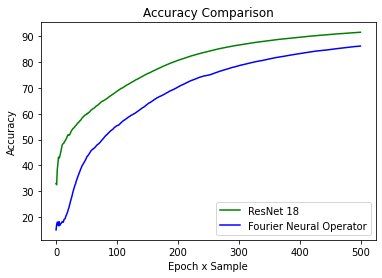

<Figure size 1440x1440 with 0 Axes>

In [ ]:
plt.plot(res.index,res.Accuracy,c="g",label="ResNet 18")
plt.plot(four.index,four.Accuracy,c="b",label="Fourier Neural Operator")
plt.title("Accuracy Comparison")
plt.legend(loc="lower right")
plt.xlabel("Epoch x Sample")
plt.ylabel("Accuracy")
plt.figure(figsize=(20,20))
plt.show()

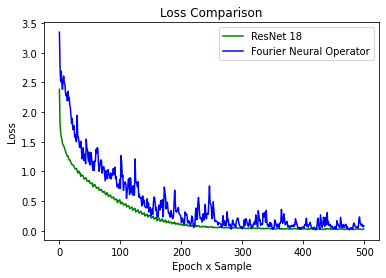

<Figure size 1440x1440 with 0 Axes>

In [ ]:
plt.plot(res.index,res.Loss,c="g",label="ResNet 18")
plt.plot(four.index,four.Loss,c="b",label="Fourier Neural Operator")
plt.title("Loss Comparison")
plt.legend(loc="upper right")
plt.xlabel("Epoch x Sample")
plt.ylabel("Loss")
plt.figure(figsize=(20,20))
plt.show()